# Considerando todas as variáveis e com validação cruzada

Aplicando os modelos para bases desbalanceadas, com nearmiss e com smote na base de treino

# Importanto bibliotecas

In [42]:
#Biblioteca/Função para ignorar avisos
import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

#caso não tenha biblioteca instalada
!pip install imblearn

import statsmodels.api as sm

import matplotlib.pyplot as plt
import pandas as pd

#ferramnenta de visualização de dados
import seaborn as sns
import numpy as np
import random
from collections import Counter

#ferramenta para avaliar relação entre variáveis e a target
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from functools import partial

#Biblioteca para os algoritmos
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

#biblioteca para selecionar as amostras
from sklearn.model_selection import train_test_split

#biblioteca para trabalhar com bases desbalanceadas
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import NearMiss


# Importando o Make Scorer
from sklearn.metrics import make_scorer

# Importando os módulos de cálculo de métricas
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

#bibliotecas para avaliação de desempenho dos classificadores
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score,
                             classification_report, f1_score,precision_recall_fscore_support)
from sklearn.metrics import (roc_auc_score, mean_squared_error)

#avaliar importancia das features nos modelos
from sklearn.inspection import permutation_importance

#graficos ficarão in line e será vetorizado (bonito)
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# Importanto data set com atraso >=30 dias

In [43]:
#pd.set_option('display.precision',16)
#df = pd.read_csv("20220111_CapitalGiro.csv", sep=';',encoding = 'ANSI',low_memory=True)

#Observar o nome da planilha dentro do arquivo do Excell: "BASE >=30", "BASE>=60", "BASE>=90"
df_30 = pd.read_excel("20220125_1_CapitalGiro DATA SET PYTHON.xlsx", sheet_name= "BASE >=30_1")

#Deletar colunas
#del  df_30['Qtde_Reneg']
#del  df_30['RAT_CONTRATO']

df_30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ATRASO >=30         250 non-null    int64  
 1   PZ_CONTRATO         250 non-null    int64  
 2   Vlr_Contrato        250 non-null    float64
 3   Taxa_Efetiva_Anual  250 non-null    float64
 4   RAT_CONTRATO        250 non-null    int64  
 5   RAT_OPERACAO        250 non-null    float64
 6   RAT_CLIENTE         250 non-null    float64
 7   Qtde_Reneg          250 non-null    int64  
 8   SCR                 250 non-null    int64  
 9   IBOVESPA            250 non-null    float64
 10  INFLAÇÃO            250 non-null    float64
 11  SELIC               250 non-null    float64
 12  PIB                 250 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 25.5 KB


# Descrevendo informações do data set

In [44]:
#https://www.youtube.com/watch?v=J456JdeWazQ

df_30.describe()

,ATRASO >=30,PZ_CONTRATO,Vlr_Contrato,Taxa_Efetiva_Anual,RAT_CONTRATO,RAT_OPERACAO,RAT_CLIENTE,Qtde_Reneg,SCR,IBOVESPA,INFLAÇÃO,SELIC,PIB
count,250.000000,250.000000,2.500000e+02,250.000000,250.0,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.500000,1013.280000,3.386034e+06,16.168577,0.0,0.019075,0.025471,0.004000,161.260000,14.630610,0.328594,-0.034293,0.001262
std,0.501003,295.297212,5.587668e+06,18.655023,0.0,0.028128,0.046142,0.063246,531.490448,11.946964,0.109814,0.028633,0.009090
min,0.000000,60.000000,1.000000e+05,0.001080,0.0,0.000000,0.000000,0.000000,2.000000,1.965477,0.086217,-0.122029,-0.030521
25%,0.000000,1080.000000,1.000000e+06,11.328458,0.0,0.005000,0.004000,0.000000,25.000000,5.313509,0.270592,-0.052265,0.000089
50%,0.500000,1080.000000,2.000000e+06,14.328559,0.0,0.011005,0.011005,0.000000,46.500000,6.934626,0.331685,-0.029133,0.003800
75%,1.000000,1080.000000,3.997500e+06,18.997620,0.0,0.020251,0.027789,0.000000,98.500000,23.666636,0.403816,-0.016362,0.006018
max,1.000000,2070.000000,7.050000e+07,298.646599,0.0,0.299980,0.500000,1.000000,6025.000000,52.105484,0.690869,0.046974,0.033423


In [45]:
df_30.head()

,ATRASO >=30,PZ_CONTRATO,Vlr_Contrato,Taxa_Efetiva_Anual,RAT_CONTRATO,RAT_OPERACAO,RAT_CLIENTE,Qtde_Reneg,SCR,IBOVESPA,INFLAÇÃO,SELIC,PIB
0,1,1260,5000000.0,8.084000,0,0.01000,0.00000,0,57,7.372133,0.208742,-0.032125,0.005149
1,1,900,9900000.0,11.196126,0,0.01804,0.01804,0,45,29.296897,0.378715,-0.057742,-0.006151
2,1,1080,3800000.0,12.248333,0,0.00500,0.01804,0,35,6.198583,0.320780,-0.026671,0.010960
3,1,450,2000000.0,7.691829,0,0.00700,0.00700,0,59,42.516846,0.490129,-0.059249,-0.025475
4,1,1440,1770000.0,14.515585,0,0.00700,0.00000,0,57,5.295440,0.290368,-0.021892,0.004313


# Checando missing values

In [46]:
df_30.isnull().sum()

ATRASO >=30           0
PZ_CONTRATO           0
Vlr_Contrato          0
Taxa_Efetiva_Anual    0
RAT_CONTRATO          0
RAT_OPERACAO          0
RAT_CLIENTE           0
Qtde_Reneg            0
SCR                   0
IBOVESPA              0
INFLAÇÃO              0
SELIC                 0
PIB                   0
dtype: int64

# Renomeando a coluna da variável dependente

In [47]:
df_30=df_30.rename(columns={'ATRASO >=30': 'Y'})
df_30.head()

,Y,PZ_CONTRATO,Vlr_Contrato,Taxa_Efetiva_Anual,RAT_CONTRATO,RAT_OPERACAO,RAT_CLIENTE,Qtde_Reneg,SCR,IBOVESPA,INFLAÇÃO,SELIC,PIB
0,1,1260,5000000.0,8.084000,0,0.01000,0.00000,0,57,7.372133,0.208742,-0.032125,0.005149
1,1,900,9900000.0,11.196126,0,0.01804,0.01804,0,45,29.296897,0.378715,-0.057742,-0.006151
2,1,1080,3800000.0,12.248333,0,0.00500,0.01804,0,35,6.198583,0.320780,-0.026671,0.010960
3,1,450,2000000.0,7.691829,0,0.00700,0.00700,0,59,42.516846,0.490129,-0.059249,-0.025475
4,1,1440,1770000.0,14.515585,0,0.00700,0.00000,0,57,5.295440,0.290368,-0.021892,0.004313


# Visualizando distribuição das classes

In [25]:
df_30.Y.value_counts()

0    125
1    125
Name: Y, dtype: int64

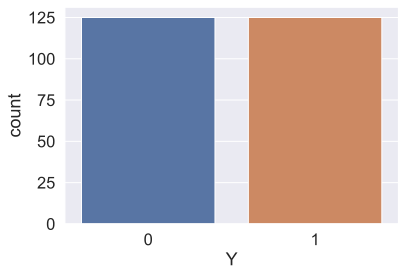

In [26]:
ax = sns.countplot(x= 'Y', data = df_30)
plt.savefig('basesbalanceadas_30.png',dpi = 300,bbox_inches='tight')

In [27]:
#df_30_Y = df_30.loc[df_30["Y"] == 0]


In [13]:
#df_30_X = df_30.loc[df_30["Y"] == 1]


In [14]:
#df_30_Y

In [15]:
#df_30_Y = pd.DataFrame(np.random.rand(10))

#indices = np.arange(0,1331,1)
#df_30_Y = df_30_Y.loc[indices]


In [16]:
#df_30_Y

In [17]:
#df_30_X

# Plotando a função densidade das variáveis disponíveis

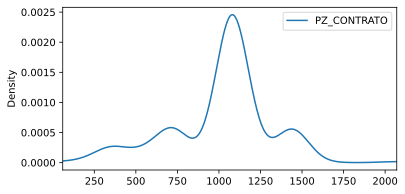

In [18]:
df_30.plot.density(y = 'PZ_CONTRATO',xlim=[60,2070], figsize = [6,3])
plt.savefig('densidade_PZ_CONTRATO_30.png',dpi = 300,bbox_inches='tight')

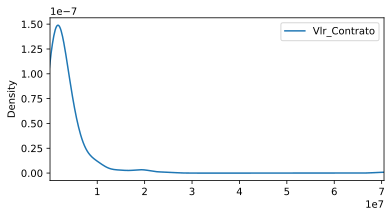

In [19]:
df_30.plot.density(y = 'Vlr_Contrato',xlim=[40000,70500000], figsize = [6,3])
plt.savefig('densidade_Vlr_Contrato_30.png',dpi = 300,bbox_inches='tight')

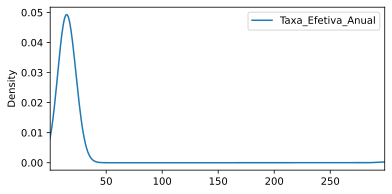

In [20]:
df_30.plot.density(y = 'Taxa_Efetiva_Anual',xlim=[0.00108,298.6464986], figsize = [6,3])
plt.savefig('densidade_Taxa_Efetiva_Anual_30.png',dpi = 300,bbox_inches='tight')

In [21]:
#df_30.plot.density(y = 'RAT_CONTRATO',xlim=[0,0], figsize = [6,3])

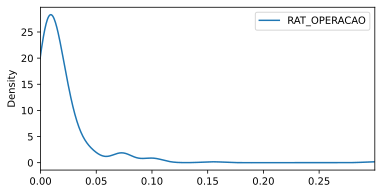

In [22]:
df_30.plot.density(y = 'RAT_OPERACAO',xlim=[0,0.29998], figsize = [6,3])
plt.savefig('densidade_RAT_OPERACAO_30.png',dpi = 300,bbox_inches='tight')

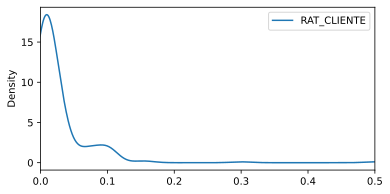

In [23]:
df_30.plot.density(y = 'RAT_CLIENTE',xlim=[0,0.5], figsize = [6,3])
plt.savefig('densidade_RAT_CLIENTE_30.png',dpi = 300,bbox_inches='tight')

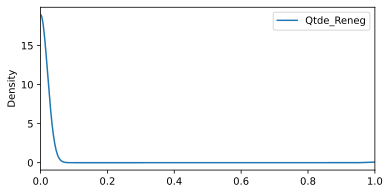

In [24]:
df_30.plot.density(y = 'Qtde_Reneg',xlim=[0,1], figsize = [6,3])
plt.savefig('densidade_Qtde_Reneg_30.png',dpi = 300,bbox_inches='tight')

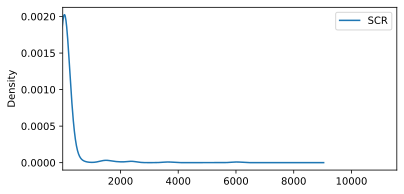

In [25]:
df_30.plot.density(y = 'SCR',xlim=[1,11570], figsize = [6,3])
plt.savefig('densidade_SCR_30.png',dpi = 300,bbox_inches='tight')

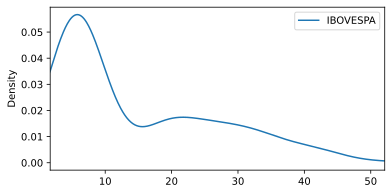

In [26]:
df_30.plot.density(y = 'IBOVESPA',xlim=[1.711198,52.105484], figsize = [6,3])
plt.savefig('densidade_IBOVESPA_30.png',dpi = 300,bbox_inches='tight')

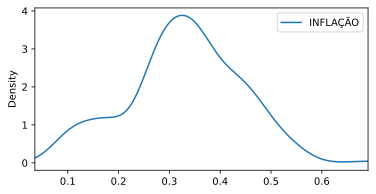

In [27]:
df_30.plot.density(y = 'INFLAÇÃO',xlim=[0.035355,0.690869], figsize = [6,3])
plt.savefig('densidade_INFLAÇÃO_30.png',dpi = 300,bbox_inches='tight')

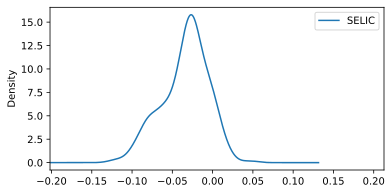

In [28]:
df_30.plot.density(y = 'SELIC',xlim=[-0.201835,0.212766], figsize = [6,3])
plt.savefig('densidade_SELIC_30.png',dpi = 300,bbox_inches='tight')

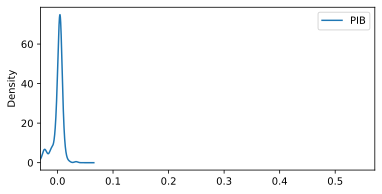

In [29]:
df_30.plot.density(y = 'PIB',xlim=[-0.030521,0.57133], figsize = [6,3])
plt.savefig('densidade_PIB_30.png',dpi = 300,bbox_inches='tight')

# Analisando o mapa de calor/heatmap 

In [30]:
#Aqui vamos verificar a correlação entre as variáveis para poder escolher melhor as 
#colunas que serão insumo para os modelos de Machine Learning

#annot diz que quero ver os valores 
# fmt = 'd, diz que os valores devem ser inteiros'
#cmap = blue, paleta de cores

corr = df_30.corr()
corr


,Y,PZ_CONTRATO,Vlr_Contrato,Taxa_Efetiva_Anual,RAT_CONTRATO,RAT_OPERACAO,RAT_CLIENTE,Qtde_Reneg,SCR,IBOVESPA,INFLAÇÃO,SELIC,PIB
Y,1.000000,-0.114012,0.049450,0.081517,NaN,0.177979,0.130364,-0.063372,0.057410,0.078417,0.036976,-0.127440,-0.224661
PZ_CONTRATO,-0.114012,1.000000,0.205581,-0.002558,NaN,-0.108990,-0.084533,0.014347,0.015813,-0.134904,0.056155,0.117572,0.140764
Vlr_Contrato,0.049450,0.205581,1.000000,0.191212,NaN,-0.114679,-0.085219,0.188805,0.027859,0.006647,0.052695,0.051226,-0.032340
Taxa_Efetiva_Anual,0.081517,-0.002558,0.191212,1.000000,NaN,0.062024,0.029815,-0.015121,-0.029617,-0.108097,-0.176306,0.082282,-0.131040
RAT_CONTRATO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RAT_OPERACAO,0.177979,-0.108990,-0.114679,0.062024,NaN,1.000000,0.573248,0.005378,-0.007058,0.193630,0.173406,-0.166959,-0.127818
RAT_CLIENTE,0.130364,-0.084533,-0.085219,0.029815,NaN,0.573248,1.000000,-0.019907,-0.009129,0.136689,0.224316,-0.151198,-0.161108
Qtde_Reneg,-0.063372,0.014347,0.188805,-0.015121,NaN,0.005378,-0.019907,1.000000,0.002597,0.032727,0.044845,-0.010712,0.035929
SCR,0.057410,0.015813,0.027859,-0.029617,NaN,-0.007058,-0.009129,0.002597,1.000000,-0.007966,0.059722,-0.006192,0.039121
IBOVESPA,0.078417,-0.134904,0.006647,-0.108097,NaN,0.193630,0.136689,0.032727,-0.007966,1.000000,0.601241,-0.621439,-0.581377


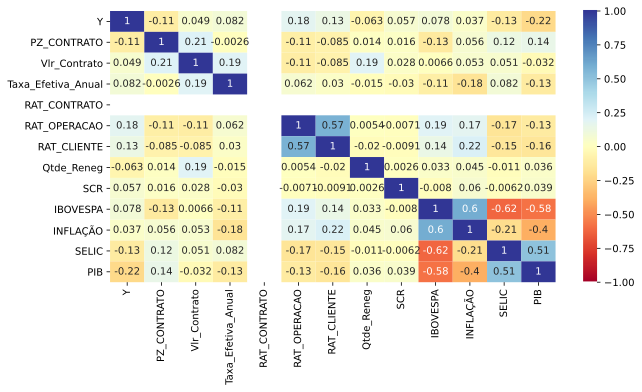

In [31]:
plt.figure(figsize = (10,5))
mapa = sns.heatmap(corr, 
                  xticklabels=corr.columns.values, 
                  yticklabels=corr.columns.values,
                  annot=True,
                  cmap="RdYlBu", 
                  linewidths = 0,
                  vmin=-1.0, 
                  vmax=1.0)
plt.savefig('mapa_calor_atraso_30',dpi = 300,bbox_inches='tight')

# Funções

# Avaliar desempenho dos modelos

In [28]:
def teste(modelo,teste_dados,teste_marcacoes,y_test,y_pred,nome):
    
    #--------cálculo da acurácia-----------------------------------------------------    
    resultado_base_teste = modelo.predict(teste_dados)   
    acuracia = accuracy_score(teste_marcacoes,resultado_base_teste)
    acuracia = round(acuracia*100,2)
    #--------------------------------------------------------------------------------
       
    #------------ cálculo das taxas de eficâcia e da taxa de achados-----------------    
    resultado_base_teste = pd.Series(resultado_base_teste)
    teste_marcacoes = pd.Series(teste_marcacoes)
    teste_marcacoes.index = range(teste_marcacoes.shape[0])
    selecao1 = resultado_base_teste == 1
    selecao2 = teste_marcacoes == 1

    contador = 0    
    for i in resultado_base_teste[selecao1].index:
        for x in teste_marcacoes[selecao2].index:
            if i == x:
                contador = contador + 1
    
    qtd_chutes = len(resultado_base_teste[resultado_base_teste==1])       
    qtd_casos = len(teste_marcacoes[teste_marcacoes==1])
    
    if qtd_chutes == 0:
        qtd_chutes = 1
        tx_precisao = 0
    else:
        tx_precisao = round((contador/qtd_chutes)*100,2)
        
    tx_achados = round((contador/qtd_casos)*100,2)
    #--------------------------------------------------------------------------------- 
    
    #------- Cálculo dos dados da Matriz de Confusão ---------------------------------
    VP = contador
    FN = qtd_casos - contador
    FP = qtd_chutes - contador
    VN = len(teste_marcacoes) - VP - FN - FP
    #---------------------------------------------------------------------------------
    
    if (VN+FN)==0:
        tx_vr_pre_neg=0
        phi=0
    else:
        tx_vr_pre_neg = round((VN/(VN+FN))*100,2)  #todo mundo foi classificado como "1"
        phi = round(((VP*VN-FP*FN))/(((VP+FP)*(VP+FN)*(VN+FP)*(VN+FN))**(1/2)),2)
        
    tx_sens = round((VP/(VP+FN))*100,2)
    tx_espec = round((VN/(VN+FP))*100,2)
    tx_efic = round((tx_sens + tx_espec)/2,2)

    if tx_precisao != 0:
        F1 = round((2*tx_precisao*tx_sens)/(tx_precisao+tx_sens),2)
    else: 
        F1 = 0
    #------IDENTIFICAÇÃO DO QUE FOI FALSO-POSITIVO. FALSO-NEGATIVO. ETC...-------------------------------
    testes = [VP,FN,FP,VN]    
    #-----------------------------------------------------------------------------------------------------
    
    #------AUC--------------------------------------------------------------------------------------------
    AUC = round(metrics.roc_auc_score(y_test,y_pred),3)
    #-----------------------------------------------------------------------------------------------------
       
                
    tabela = pd.DataFrame({nome: [str(acuracia) + '%',str(tx_precisao)+ '%',str(tx_vr_pre_neg) +'%',
                                     str(tx_sens)+ '%',str(tx_espec) + '%',str(tx_efic) + '%',str(phi),str(F1),str(AUC)]},
                                      index = ['Acurácia','Valor Preditivo Positivo','Valor Preditivo Negativo',
                                               'Sensibilidade','Especificidade','Eficiência','Coeficiente phi',
                                               'F1 Score','AUC'])
    print ("Tabela de Taxas / Coeficiente Phi / F1")
    display(tabela)       
        
    return tabela 


# Curva ROC AUC

In [29]:
def CurvaAuc(teste_total,marcacoes_total, modelo1, modelo2, modelo3, modelo4, modelo5, modelo6, 
             nome_modelo1,nome_modelo2,nome_modelo3,nome_modelo4,nome_modelo5,nome_modelo6,nome_arquivo):
    
   #------juntando os dois testes e suas respectivas marcações----------------------------
   teste_total = pd.DataFrame(teste_total)        
   teste_total = np.array(teste_total)    

   marcacoes_total = pd.DataFrame(marcacoes_total)  
   marcacoes_total = np.array(marcacoes_total)
   #--------------------------------------------------------------------------------------

   #--------predições--------------------------------------  
   predictions1 = modelo1.predict(teste_total)  
   predictions2 = modelo2.predict(teste_total)  
   predictions3 = modelo3.predict(teste_total)    
   predictions4 = modelo4.predict(teste_total)    
   predictions5 = modelo5.predict(teste_total)    
   predictions6 = modelo6.predict(teste_total)          
   #--------------------------------------------------------------      

   plt.rc('figure',figsize = (15,5))
   sns.set_context("notebook",font_scale=1.5,rc = {"lines.linewidth":1.5})
   fpr1, tpr1, thresholds = roc_curve(marcacoes_total, predictions1)
   roc_auc = auc(fpr1, tpr1)
   plt.title('Receiver Operating Characteristic')
   plt.plot(fpr1, tpr1, label='AUC' + nome_modelo1 + '= %0.4f'% roc_auc)

   fpr2, tpr2, thresholds = roc_curve(marcacoes_total, predictions2)
   roc_auc = auc(fpr2, tpr2)
   plt.plot(fpr2, tpr2, label='AUC' + nome_modelo2 + '= %0.4f'% roc_auc)

   fpr3, tpr3, thresholds = roc_curve(marcacoes_total, predictions3)
   roc_auc = auc(fpr3, tpr3)
   plt.plot(fpr3, tpr3, label='AUC' + nome_modelo3 + '= %0.4f'% roc_auc)

   fpr4, tpr4, thresholds = roc_curve(marcacoes_total, predictions4)
   roc_auc = auc(fpr4, tpr4)
   plt.plot(fpr4, tpr4, label='AUC' + nome_modelo4 + '= %0.4f'% roc_auc)

   fpr5, tpr5, thresholds = roc_curve(marcacoes_total, predictions5)
   roc_auc = auc(fpr5, tpr5)
   plt.plot(fpr5, tpr5, label='AUC' + nome_modelo5 + '= %0.4f'% roc_auc)

   fpr6, tpr6, thresholds = roc_curve(marcacoes_total, predictions6)
   roc_auc = auc(fpr6, tpr6)
   plt.plot(fpr6, tpr6, label='AUC' + nome_modelo6 + '= %0.4f'% roc_auc)  

   plt.plot([0,1],[0,1],'r--')
   plt.xlim([-0.001, 1])
   plt.ylim([0, 1.001])
   plt.ylabel('True Positive Rate')
   plt.xlabel('False Positive Rate')
   plt.legend(loc='lower right')
   plt.savefig(nome_arquivo,dpi = 300,bbox_inches='tight')
   plt.show() 

# Seleção de Variáveis com validação cruzada

In [35]:
def SelectVar_bd(X_train, y_train, X_test,y_test,k):

  # Models instances.
  logisticRegression = LogisticRegression(l1_ratio=0, max_iter=100, n_jobs=-1, solver = 'liblinear', 
                                            penalty = 'l1', tol=0.1, verbose=0, random_state = 10, fit_intercept=True)

  decisionTreeClassifier = DecisionTreeClassifier(class_weight=None,criterion='entropy',max_depth=5,min_samples_leaf=10, 
                                                     min_samples_split=10, splitter='best',random_state = 10)
                           
  randomForestClassifier = RandomForestClassifier(class_weight= None, n_estimators=100, max_depth=5, 
                                                  min_samples_split=2, min_samples_leaf=3, 
                                                  max_features='sqrt', bootstrap=True)
                                                  
  baggingClassifier = BaggingClassifier(max_samples = 1, max_features=0.5,bootstrap_features=False, 
                                 n_estimators=5, n_jobs=-1, bootstrap=True, random_state = 10)

  gradientBoostingClassifier = GradientBoostingClassifier(learning_rate=0.5, n_estimators=80, 
                                tol=0.001,random_state = 10)


  adaBoostClassifier = AdaBoostClassifier(learning_rate=2,n_estimators=50, random_state = 10, 
                                        algorithm='SAMME')

  # Técnica 01 - Multi Information Classification
  #Se X e Y são independentes, então nenhuma informação sobre Y pode ser obtida conhecendo X ou vice-versa. 
  #Portanto sua informação mútua é 0. Se X é uma função determinística de Y, então podemos determinar 
  #X de Y e Y de X com informação mútua 1. Quanto menor o valor, menos a variavel descreve a relação com o Target!
  #A vantagem de usar informações mútuas sobre o F-Test é que ele se dá bem com a relação não linear entre 
  #as variáveis explicativas e à Target.
  #Quanto maior o valor melhor.
  #Estimativa de informação mútua para uma variável alvo discreta.
  #A informação mútua (MI) [1] entre duas variáveis aleatórias é um valor não-negativo, 
  #que mede a dependência entre as variáveis. É igual a zero se e só se duas variáveis aleatórias 
  #forem independentes, e valores mais elevados significam uma dependência mais elevada.
  #A função baseia-se em métodos não paramétricos baseados na estimativa da entropia das distâncias 
  #k-nearest vizinhas. 
   
  #links para estudo
  # https://medium.com/@alegeorgelustosa/m%C3%A9todos-para-selecionar-as-melhores-vari%C3%A1veis-do-dataset-em-python-2c374b2e9df2
  # https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html
  
  mi = mutual_info_classif(X_train.fillna(0),y_train, random_state = 10, n_neighbors=3)
  mi 

  mi = pd.Series(mi)
  mi.index = X_train.columns
  mi = mi.sort_values(ascending = False)
  mi.plot.bar(figsize = (8,5))
  plt.xlabel('Variáveis')
  plt.ylabel('Mutual Information')
  plt.title('Atraso>=30 dias')
  plt.savefig('Multi_Inform_Class_bd_30',dpi = 300,bbox_inches='tight') 


  #Técnica 02 - Usando a classe SelectKBest da biblioteca feature_selection combinada com o 
  #método de máximo coeficiente de informações para selecionar as melhores variáveis
  #links para estudo
  #https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

  # k é a quantidade de variáveis para eu avaliar
  sel_ = SelectKBest(mutual_info_classif, k = k).fit(X_train.fillna(0),y_train)
  X_train.columns[sel_.get_support()]

  list(X_train.columns[sel_.get_support()])
 
  print (mi)  

  #Técnica 03 - Usando ROC - AUC
  #Criação do laço para prencher a variável roc_value com as predições

  
  list_models = [logisticRegression,decisionTreeClassifier,randomForestClassifier,
                 baggingClassifier,gradientBoostingClassifier,adaBoostClassifier]  
  figure, axis = plt.subplots(nrows = 6,figsize = (8,40))   
  i = 0  
  for model in list_models:
        roc_values = []      
        for feature in X_train.columns:
            model.fit(X_train[feature].fillna(0).to_frame(),y_train)
            y_score = model.predict_proba(X_test[feature].fillna(0).to_frame())
            roc_values.append(roc_auc_score(y_test, y_score[:,1]))
        roc_values
        roc_values = pd.Series(roc_values)
        roc_values.index = X_train.columns
        roc_values.sort_values(ascending= False)[0:12]
        #roc_values.sort_values(ascending= False).plot.bar(figsize = (8,7))
        axis[i].plot(roc_values.sort_values(ascending= False))
        axis[i].set_title(model)
        #axis[i].set_xticklabels(axis[i].get_xticklabels(), rotation= 90)
        for label in axis[i].get_xticklabels():
            label.set_rotation(90)
        i=i+1
        plt.ylabel('LIMIAR')      
        plt.xlabel('VARIÁVEIS')   
        print('O ', model, 'possui ',len(roc_values[roc_values>0.5]),'variáveis com AUC acima do limiar de 0,5 ')
  figure.tight_layout()
  plt.savefig('auc_variaveis_bd_30.png',dpi = 300,bbox_inches='tight') 
  plt.show()
     
       
#https://acervolima.com/plotar-multiplos-graficos-em-matplotlib/

# BASE 

250
175
75
IBOVESPA              0.128475
PIB                   0.115139
SELIC                 0.049585
INFLAÇÃO              0.028296
SCR                   0.024492
RAT_OPERACAO          0.008240
PZ_CONTRATO           0.000000
Vlr_Contrato          0.000000
Taxa_Efetiva_Anual    0.000000
RAT_CONTRATO          0.000000
RAT_CLIENTE           0.000000
Qtde_Reneg            0.000000
dtype: float64


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\sab

O  LogisticRegression(l1_ratio=0, n_jobs=-1, penalty='l1', random_state=10,
                   solver='liblinear', tol=0.1) possui  3 variáveis com AUC acima do limiar de 0,5 
O  DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=10,
                       min_samples_split=10, random_state=10) possui  9 variáveis com AUC acima do limiar de 0,5 
O  RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=3) possui  8 variáveis com AUC acima do limiar de 0,5 
O  BaggingClassifier(max_features=0.5, max_samples=1, n_estimators=5, n_jobs=-1,
                  random_state=10) possui  0 variáveis com AUC acima do limiar de 0,5 
O  GradientBoostingClassifier(learning_rate=0.5, n_estimators=80, random_state=10,
                           tol=0.001) possui  8 variáveis com AUC acima do limiar de 0,5 
O  AdaBoostClassifier(algorithm='SAMME', learning_rate=2, random_state=10) possui  6 variáveis com AUC acima do limiar de 0,5 


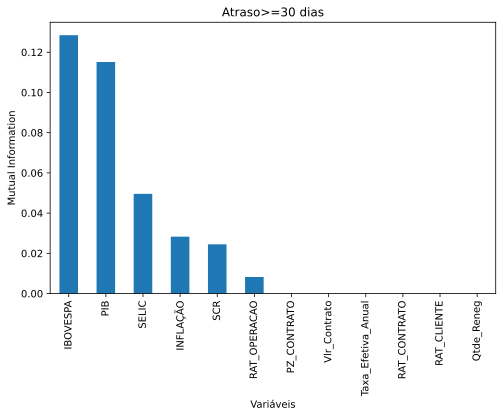

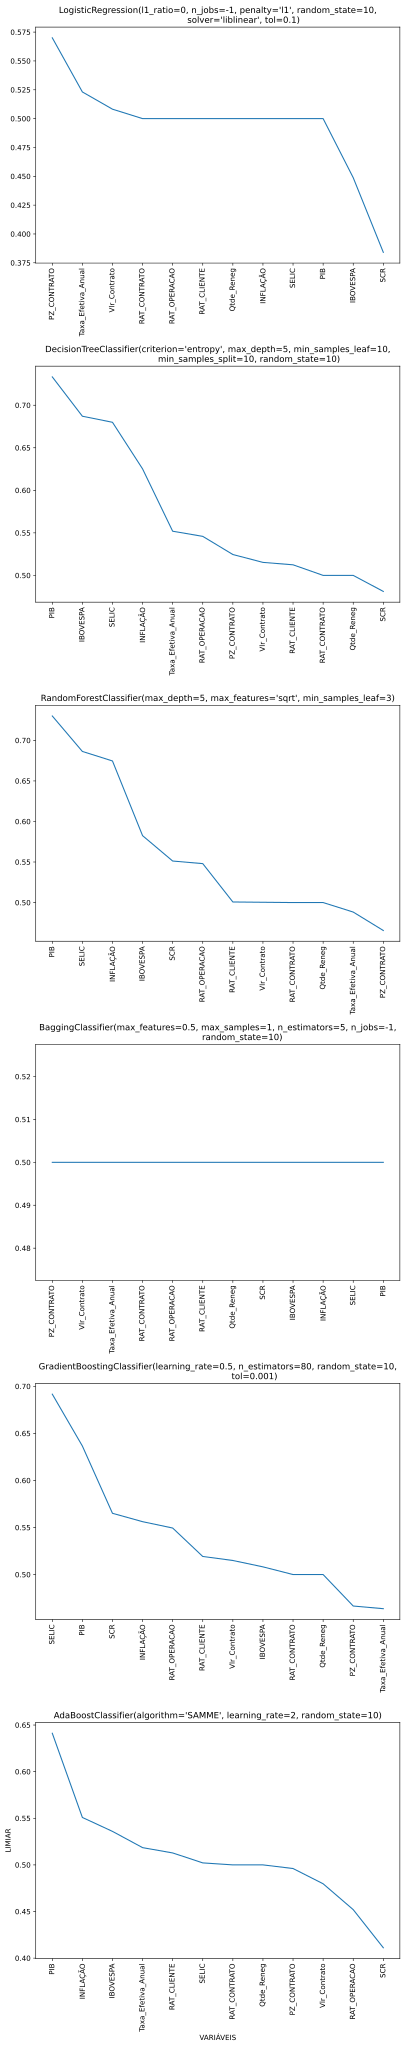

In [36]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

SelectVar_bd(X_train,y_train,X_test,y_test,12)

# Seleção de parâmetros com validação cruzada - GRIDESEARCH

https://andersonuyekita.github.io/notebooks/blog/2019/03/21/como-usar-o-gridsearchcv/

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score

https://medium.com/data-hackers/como-avaliar-seu-modelo-de-classifica%C3%A7%C3%A3o-34e6f6011108


In [38]:
def SelectParlr(X_train,y_train,k):
            
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #LOGIST REGRESSION
    #https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
        
    param_grid = {'fit_intercept': [True],
         'l1_ratio': ['None',0,0.5,1],
         'max_iter': [50,100,150],
         'n_jobs': [-1,'None',1],
         'tol': [0.0001,0.001,0.1],
         'verbose': [0,1,2],
         'penalty': ['l1', 'l2','none'],   #penalidades suportadas pela lbfgs e liblinear abaixo
         'solver': ['lbfgs','liblinear']  #usados em pequenos datasets
        }
      
    # Models instances.
    logisticRegression = LogisticRegression()
    
    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm           
    LogisticRegression_grid_search = GridSearchCV(logisticRegression, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True, #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')
    LogisticRegression_grid_search.fit(X_train, y_train)
    print(LogisticRegression_grid_search.best_params_)
    print(LogisticRegression_grid_search.best_estimator_)
    print(LogisticRegression_grid_search.best_score_)
    return LogisticRegression_grid_search

In [39]:
def SelectPardt(X_train,y_train,k):
    
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #DECISION TREE
    #https://scikit-learn.org/stable/modules/tree.html#tree
    #Para classificação com poucas classes, min_samples_leaf=1 é muitas vezes a melhor escolha.
    #Equilibre o seu conjunto de dados antes do treino para evitar que a árvore seja enviesada para as classes que são dominantes.
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
    
    param_grid = {'splitter': ['best', 'random'],
        'criterion': ['gini', 'entropy'],   #formula matematica que melhor separa as duas classes 0 e 1, cada uma com uma curva diferente
        'min_samples_leaf': [2,5,10],
        'max_depth': [2,3,4,5],
        'min_samples_split': [2,5,10],
        'class_weight': [None, 'balanced']   #traz mais peso para a base menos balanceada, tentando balancear o peso das arvores
       }
     
    # Models instances.
    decisionTreeClassifier = DecisionTreeClassifier()
    
    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm 
    DecisionTreeClassifier_grid_search = GridSearchCV(decisionTreeClassifier, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True,  #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')
    print (DecisionTreeClassifier_grid_search.fit(X_train, y_train))
    print (DecisionTreeClassifier_grid_search.best_params_)
    print (DecisionTreeClassifier_grid_search.best_estimator_)
    print (DecisionTreeClassifier_grid_search.best_score_)
    return DecisionTreeClassifier_grid_search

In [40]:
def SelectParrf(X_train,y_train,k):
    
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #RANDOM FOREST
    
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
    
    param_grid ={'bootstrap': [True],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [3,5],
        'n_estimators': [100,350,500],
        'max_depth': [2,3,4,5],
        'min_samples_split': [0.5,2,3,4],
        'class_weight': [None, 'balanced']   #traz mais peso para a base menos balanceada, tentando balancear o peso das arvores
      }
     
    # Models instances.
    randomForestClassifier = RandomForestClassifier()
    
    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm 
    RandomForestClassifier_grid_search = GridSearchCV(randomForestClassifier, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True, #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')

    print (RandomForestClassifier_grid_search.fit(X_train, y_train))
    print (RandomForestClassifier_grid_search.best_params_)
    print (RandomForestClassifier_grid_search.best_estimator_)
    print (RandomForestClassifier_grid_search.best_score_)
    return RandomForestClassifier_grid_search

In [41]:
def SelectParbc(X_train,y_train,k):
    
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #BAGGING CLASSIFIER
    #https://scikit-learn.org/stable/modules/ensemble.html#bagging
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html?highlight=bagging%20classifier#sklearn.ensemble.BaggingClassifier
    #Quando as amostras são desenhadas com substituição, então o método é conhecido como Bagging 
    #m particular, max_samples e max_features controlam o tamanho dos subconjuntos 
    #em termos de amostras e características), enquanto que bootstrap e bootstrap_features 
    #controlam se as amostras e características são desenhadas com ou sem substituição.
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
    
    
    param_grid = {'bootstrap': [True],
        'bootstrap_features': [False],
        'n_jobs': [-1,1],
        'max_samples': [0,1,2,3,4,5,6,7],        
        'max_features': [0.5,1,2],
        'n_estimators': [5,10,50,100,200, 500]
       }
     
   # Models instances.
    baggingClassifier = BaggingClassifier()
    
    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm 
    BaggingClassifier_grid_search = GridSearchCV(baggingClassifier, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True, #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')

    print (BaggingClassifier_grid_search.fit(X_train, y_train))
    print (BaggingClassifier_grid_search.best_params_)
    print (BaggingClassifier_grid_search.best_estimator_)
    print (BaggingClassifier_grid_search.best_score_)
    return BaggingClassifier_grid_search

In [42]:
def SelectPargb(X_train,y_train,k):
    
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #GRADIENT BOOSTING
    #Aspectos importantes para considerar: 
    # número de alunos fracos (numero de arvos) é controlado pelo parâmetro n_estimadores.
    #The 2 most important parameters of these estimators are n_estimators and learning_rate.
    #https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
    
    param_grid = {'tol': [0.0001,0.001,0.1],
        #'max_depth': [1,2,3,4,5,6,7,8,9,10],     #relacionados a decision tree
        #'min_samples_split':[1,2,3,4,5,6],      #relacionados a decision tree 
        'learning_rate': [0.5,1,2,3,10,20],   #controla o overfitting entre [0 e 1]
        'n_estimators': [80,100,150,300,500]
       }
         
   # Models instances.
    gradientBoostingClassifier = GradientBoostingClassifier()

    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm 
    GradientBoostingClassifier_grid_search = GridSearchCV(gradientBoostingClassifier, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True,  #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')

    print (GradientBoostingClassifier_grid_search.fit(X_train, y_train))
    print (GradientBoostingClassifier_grid_search.best_params_)
    print (GradientBoostingClassifier_grid_search.best_estimator_)
    print (GradientBoostingClassifier_grid_search.best_score_)
    return GradientBoostingClassifier_grid_search

In [56]:
def SelectParab(X_train,y_train,k):
    
    # k define a quantidade de kfolds na validação cruzada
    np.random.seed(10)
    cv = StratifiedKFold(n_splits = k, shuffle = True)
    #ADABOOST
    #https://scikit-learn.org/stable/modules/ensemble.html#adaboost
    #Aspectos que mais podem impactar:  
    # número de alunos fracos (numero de arvos) é controlado pelo parâmetro n_estimadores.
    # O parâmetro learning_rate controla a contribuição dos aprendentes fracos na combinação final.
    #Os principais parâmetros a afinar para obter bons resultados são os n_estimadores
    #e a complexidade dos estimadores de base (por exemplo, a sua profundidade máxima_profundidade 
    #ou o número mínimo exigido de amostras para considerar uma divisão de min_amostragens).
    
    
    # Criando um dicionário com as métricas que desejo calcular.
    meus_scores = {'balanced_accuracy' :make_scorer(balanced_accuracy_score),
                   'recall'   :make_scorer(recall_score),
                   'precision':make_scorer(precision_score),
                   'f1'       :make_scorer(fbeta_score, beta = 1)}  #quanto mais beta proximo de 1, melhor recall
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score 
    
    param_grid = {'algorithm': ['SAMME','SAMME.R'],
        #'max_depth': [1,2,3,4,5,6,7,8,9,10],        #relacionados a decision tree
        #'min_samples_split':[1,2,3,4,5,6],         #relacionados a decision tree
        'learning_rate': [1,2,3],    #controla o overfitting entre [0 e 1]
        'n_estimators': [50,100,300,500]
       }
         
   # Models instances.
    adaBoostClassifier = AdaBoostClassifier()

    #usar scoring = recall procuro sensibilidade
    #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
    #https://scikit-learn.org/stable/modules/model_evaluation.htm 
    AdaBoostClassifier_grid_search = GridSearchCV(adaBoostClassifier, 
                                  param_grid,cv=cv,
                                  scoring = meus_scores,
                                  return_train_score=True,
                                  verbose=True,  #enquanto treina escreve na tela o que esta fazendo, quanto maior o numero mais informacao aparece na tela
                                  n_jobs=-1,
                                  refit = 'f1')

    print (AdaBoostClassifier_grid_search.fit(X_train, y_train))
    print (AdaBoostClassifier_grid_search.best_params_)
    print (AdaBoostClassifier_grid_search.best_estimator_)
    print (AdaBoostClassifier_grid_search.best_score_)
    return AdaBoostClassifier_grid_search

# BASES BALANCEADAS

In [44]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

250
175
75


In [45]:
lrgride5_bd = SelectParlr(X_train,y_train,5)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
[LibLinear]{'fit_intercept': True, 'l1_ratio': 0, 'max_iter': 100, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1, 'verbose': 2}
LogisticRegression(l1_ratio=0, n_jobs=-1, penalty='l1', solver='liblinear',
                   tol=0.1, verbose=2)
0.538183296078033


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5400 fits failed out of a total of 9720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError

In [46]:
lrgride10_bd = SelectParlr(X_train,y_train,10)

Fitting 10 folds for each of 1944 candidates, totalling 19440 fits
[LibLinear]{'fit_intercept': True, 'l1_ratio': 0, 'max_iter': 150, 'n_jobs': 1, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1, 'verbose': 2}
LogisticRegression(l1_ratio=0, max_iter=150, n_jobs=1, penalty='l1',
                   solver='liblinear', tol=0.1, verbose=2)
0.526949585502217


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10800 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueErr

In [47]:
dtgride5_bd = SelectPardt(X_train,y_train,5)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 

In [48]:
dtgride10_bd = SelectPardt(X_train,y_train,10)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split'

In [49]:
rfgride5_bd = SelectParrf(X_train,y_train,5)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [0.5, 2, 3, 4],
                         'n_estimators': [100, 350, 500]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 

In [50]:
rfgride10_bd = SelectParrf(X_train,y_train,10)

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': [None, 'balanced'],
                         'max_depth': [2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [0.5, 2, 3, 4],
                         'n_estimators': [100, 350, 500]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'bootstrap': True, 'class_weight': None, 'max_depth': 5, '

In [51]:
bcgride5_bd = SelectParbc(X_train,y_train,5)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 328, in _fit
    raise ValueError("max_samples

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'bootstrap_features': [False],
                         'max_features': [0.5, 1, 2],
                         'max_samples': [0, 1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [5, 10, 50, 100, 200, 500],
                         'n_jobs': [-1, 1]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1, 'n_estimators': 5, 'n_jobs': -1}
BaggingClassifier(max_features=0.5, max_samples=1, n_estimators=5, n_jobs=-1)
0.6640058055

In [52]:
bcgride10_bd = SelectParbc(X_train,y_train,10)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
360 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 269, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py", line 328, in _fit
    raise ValueError("max_samples

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'bootstrap_features': [False],
                         'max_features': [0.5, 1, 2],
                         'max_samples': [0, 1, 2, 3, 4, 5, 6, 7],
                         'n_estimators': [5, 10, 50, 100, 200, 500],
                         'n_jobs': [-1, 1]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 2, 'max_samples': 3, 'n_estimators': 5, 'n_jobs': -1}
BaggingClassifier(max_features=2, max_samples=3, n_estimators=5, n_jobs=-1)
0.6145667306549

In [53]:
gbgride5_bd = SelectPargb(X_train,y_train,5)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1, 2, 3, 10, 20],
                         'n_estimators': [80, 100, 150, 300, 500],
                         'tol': [0.0001, 0.001, 0.1]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'learning_rate': 0.5, 'n_estimators': 300, 'tol': 0.001}
GradientBoostingClassifier(learning_rate=0.5, n_estimators=300, tol=0.001)
0.6073616473616473


In [54]:
gbgride10_bd = SelectPargb(X_train,y_train,10)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1, 2, 3, 10, 20],
                         'n_estimators': [80, 100, 150, 300, 500],
                         'tol': [0.0001, 0.001, 0.1]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'learning_rate': 0.5, 'n_estimators': 80, 'tol': 0.001}
GradientBoostingClassifier(learning_rate=0.5, n_estimators=80, tol=0.001)
0.6184453781512604


In [57]:
adgride5_bd = SelectParab(X_train,y_train,5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1, 2, 3],
                         'n_estimators': [50, 100, 300, 500]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'algorithm': 'SAMME', 'learning_rate': 2, 'n_estimators': 50}
AdaBoostClassifier(algorithm='SAMME', learning_rate=2)
0.6283722105462016


In [58]:
adgride10_bd = SelectParab(X_train,y_train,10)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1, 2, 3],
                         'n_estimators': [50, 100, 300, 500]},
             refit='f1', return_train_score=True,
             scoring={'balanced_accuracy': make_scorer(balanced_accuracy_score),
                      'f1': make_scorer(fbeta_score, beta=1),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)},
             verbose=True)
{'algorithm': 'SAMME', 'learning_rate': 2, 'n_estimators': 50}
AdaBoostClassifier(algorithm='SAMME', learning_rate=2)
0.6415652173913043


In [59]:
  #BASE DESBALANCEADAS
    
    # Creates a dictionary  
dic_params5_bd = {
   "LogisticRegression": lrgride5_bd.best_params_,
   "DecisionTreeClassifier": dtgride5_bd.best_params_,
   "RandomForestClassifier": rfgride5_bd.best_params_,
   "BaggingClassifier": bcgride5_bd.best_params_,
   "GradientBoostingClassifier": gbgride5_bd.best_params_,
   "AdaBoostClassifier": adgride5_bd.best_params_
  }

  # Creates a dictionary  
dic_score5_bd = {
   "LogisticRegression": lrgride5_bd.best_score_,
   "DecisionTreeClassifier": dtgride5_bd.best_score_,
   "RandomForestClassifier": rfgride5_bd.best_score_,
   "BaggingClassifier": bcgride5_bd.best_score_,
   "GradientBoostingClassifier": gbgride5_bd.best_score_,
   "AdaBoostClassifier": adgride5_bd.best_score_
  }

  # Creates a dictionary  
dic_params10_bd = {
   "LogisticRegression": lrgride10_bd.best_params_,
   "DecisionTreeClassifier": dtgride10_bd.best_params_,
   "RandomForestClassifier": rfgride10_bd.best_params_,
   "BaggingClassifier": bcgride10_bd.best_params_,
   "GradientBoostingClassifier": gbgride10_bd.best_params_,
   "AdaBoostClassifier": adgride10_bd.best_params_
  }

  # Creates a dictionary  
dic_score10_bd = {
   "LogisticRegression": lrgride10_bd.best_score_,
   "DecisionTreeClassifier": dtgride10_bd.best_score_,
   "RandomForestClassifier": rfgride10_bd.best_score_,
   "BaggingClassifier": bcgride10_bd.best_score_,
   "GradientBoostingClassifier": gbgride10_bd.best_score_,
   "AdaBoostClassifier": adgride10_bd.best_score_
  }

In [62]:
dic_params5_bd

{'LogisticRegression': {'fit_intercept': True,
  'l1_ratio': 0,
  'max_iter': 100,
  'n_jobs': -1,
  'penalty': 'l1',
  'solver': 'liblinear',
  'tol': 0.1,
  'verbose': 2},
 'DecisionTreeClassifier': {'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 10,
  'min_samples_split': 2,
  'splitter': 'best'},
 'RandomForestClassifier': {'bootstrap': True,
  'class_weight': 'balanced',
  'max_depth': 5,
  'max_features': 'auto',
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 100},
 'BaggingClassifier': {'bootstrap': True,
  'bootstrap_features': False,
  'max_features': 0.5,
  'max_samples': 1,
  'n_estimators': 5,
  'n_jobs': -1},
 'GradientBoostingClassifier': {'learning_rate': 0.5,
  'n_estimators': 300,
  'tol': 0.001},
 'AdaBoostClassifier': {'algorithm': 'SAMME',
  'learning_rate': 2,
  'n_estimators': 50}}

In [63]:
dic_params10_bd

{'LogisticRegression': {'fit_intercept': True,
  'l1_ratio': 0,
  'max_iter': 150,
  'n_jobs': 1,
  'penalty': 'l1',
  'solver': 'liblinear',
  'tol': 0.1,
  'verbose': 2},
 'DecisionTreeClassifier': {'class_weight': None,
  'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 10,
  'min_samples_split': 10,
  'splitter': 'best'},
 'RandomForestClassifier': {'bootstrap': True,
  'class_weight': None,
  'max_depth': 5,
  'max_features': 'sqrt',
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 100},
 'BaggingClassifier': {'bootstrap': True,
  'bootstrap_features': False,
  'max_features': 2,
  'max_samples': 3,
  'n_estimators': 5,
  'n_jobs': -1},
 'GradientBoostingClassifier': {'learning_rate': 0.5,
  'n_estimators': 80,
  'tol': 0.001},
 'AdaBoostClassifier': {'algorithm': 'SAMME',
  'learning_rate': 2,
  'n_estimators': 50}}

In [64]:
dic_score5_bd

{'LogisticRegression': 0.538183296078033,
 'DecisionTreeClassifier': 0.603653808607369,
 'RandomForestClassifier': 0.5829338429338429,
 'BaggingClassifier': 0.6640058055152395,
 'GradientBoostingClassifier': 0.6073616473616473,
 'AdaBoostClassifier': 0.6283722105462016}

In [65]:
dic_score10_bd

{'LogisticRegression': 0.526949585502217,
 'DecisionTreeClassifier': 0.6202121278013053,
 'RandomForestClassifier': 0.5839130915524103,
 'BaggingClassifier': 0.614566730654966,
 'GradientBoostingClassifier': 0.6184453781512604,
 'AdaBoostClassifier': 0.6415652173913043}

# BASES BALANCEADAS - aplicando os melhores parâmetros CV

# Executando Algoritmo Logist Regression 

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logist%20regression#sklearn.linear_model.LogisticRegression

In [30]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe
#Para data sets pequenos >> solver = 'liblinear'
#Parâmetros considerados por default: C, class_weight, dual, fit_intercept, intercept_scaling,
#l1_ratio, max_iter, multi_class, n_jobs, penalty, tol, verbose e warm_start

lr_30_bd = LogisticRegression(l1_ratio=0, max_iter=100, n_jobs=-1, solver = 'liblinear', penalty = 'l1',
                              tol=0.1, verbose=2,random_state = 10, fit_intercept=True)

#Treinando o algoritmo
lr_30_bd.fit(X_train,y_train, sample_weight=None)

#Colocar as classificações na variável y_pred
y_pred = lr_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(lr_30_bd,X_test,y_test,y_test,y_pred, "Logist Regression Bases Balanceadas")


tabela_LogistRegressionBasesBalanceadas = tabela
tabela_LogistRegressionBasesBalanceadas

Matriz_Confusao_30_lr_bd = confusion_matrix(y_test,y_pred)

250
175
75
[LibLinear]Tabela de Taxas / Coeficiente Phi / F1


C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


,Logist Regression Bases Balanceadas
Acurácia,52.0%
Valor Preditivo Positivo,52.38%
Valor Preditivo Negativo,51.52%
Sensibilidade,57.89%
Especificidade,45.95%
Eficiência,51.92%
Coeficiente phi,0.04
F1 Score,55.0
AUC,0.519


# Executando Algoritmo Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontree#sklearn.tree.DecisionTreeClassifier


In [31]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe

dt_30_bd = DecisionTreeClassifier(class_weight= None, criterion='entropy',max_depth=5,min_samples_leaf=10, 
                                  min_samples_split=10,
                                  splitter='best',random_state = 10)

#Treinando o algoritmo
dt_30_bd.fit(X_train,y_train)

#Colocar as classficações na variável y_pred
y_pred = dt_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(dt_30_bd,X_test,y_test,y_test,y_pred, "Decision Tree Bases Balanceadas")


tabela_DecisionTreeBasesBalanceadas = tabela
tabela_DecisionTreeBasesBalanceadas

Matriz_Confusao_30_dt_bd = confusion_matrix(y_test,y_pred)

250
175
75
Tabela de Taxas / Coeficiente Phi / F1


,Decision Tree Bases Balanceadas
Acurácia,66.67%
Valor Preditivo Positivo,76.0%
Valor Preditivo Negativo,62.0%
Sensibilidade,50.0%
Especificidade,83.78%
Eficiência,66.89%
Coeficiente phi,0.36
F1 Score,60.32
AUC,0.669


# Executando Algoritmo Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [32]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe

rf_30_bd = RandomForestClassifier (class_weight=None, n_estimators=100, max_depth=5, min_samples_split=2,
                                   min_samples_leaf=3, 
                                   max_features='sqrt', bootstrap=True,random_state = 10)

#Treinando o algoritmo
rf_30_bd.fit(X_train,y_train)

#Colocar as classficações na variável y_pred
y_pred = rf_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(rf_30_bd,X_test,y_test,y_test,y_pred, "Random Forest Bases Balanceadas")


tabela_RandomForestBasesBalanceadas = tabela
tabela_RandomForestBasesBalanceadas

Matriz_Confusao_30_rf_bd = confusion_matrix(y_test,y_pred)

250
175
75
Tabela de Taxas / Coeficiente Phi / F1


,Random Forest Bases Balanceadas
Acurácia,69.33%
Valor Preditivo Positivo,75.86%
Valor Preditivo Negativo,65.22%
Sensibilidade,57.89%
Especificidade,81.08%
Eficiência,69.48%
Coeficiente phi,0.4
F1 Score,65.67
AUC,0.695


# Executando Algoritmo - BAGGING CLASSIFIER

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html?highlight=bagging%20classifier#sklearn.ensemble.BaggingClassifier


In [33]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe
# base estimator é o padrao 
# max_sample é o padrao 
#amostragem sem reposição 
#amostragem de features sem reposição 

bc_30_bd = BaggingClassifier(max_samples = 1, max_features=0.5,bootstrap_features=False, 
                             n_estimators=5, n_jobs=-1, bootstrap=True, random_state = 10)

#Treinando o algoritmo
bc_30_bd.fit(X_train,y_train)

#Colocar as classficações na variável y_pred
y_pred = bc_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(bc_30_bd,X_test,y_test,y_test,y_pred, "Bagging Classifier Bases Balanceadas")


tabela_BaggingClassifierBasesBalanceadas = tabela
tabela_BaggingClassifierBasesBalanceadas

Matriz_Confusao_30_bc_bd = confusion_matrix(y_test,y_pred)

250
175
75
Tabela de Taxas / Coeficiente Phi / F1


,Bagging Classifier Bases Balanceadas
Acurácia,49.33%
Valor Preditivo Positivo,0%
Valor Preditivo Negativo,48.65%
Sensibilidade,0.0%
Especificidade,97.3%
Eficiência,48.65%
Coeficiente phi,-0.12
F1 Score,0
AUC,0.5


# Executando Algoritmo Gradient Boosting

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html?highlight=gradient%20boosting#sklearn.ensemble.GradientBoostingClassifier


In [34]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe
# base estimator é o padrao 
# max_sample é o padrao 

gb_30_bd = GradientBoostingClassifier(learning_rate=0.5, n_estimators=80, tol=0.001,random_state = 10)

#Treinando o algoritmo
gb_30_bd.fit(X_train,y_train)

#Colocar as classficações na variável y_pred
y_pred = gb_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(gb_30_bd,X_test,y_test,y_test,y_pred, "Gradiente Boosting Bases Balanceadas")


tabela_GradianteBoostingBasesBalanceadas = tabela
tabela_GradianteBoostingBasesBalanceadas

Matriz_Confusao_30_gb_bd = confusion_matrix(y_test,y_pred)

250
175
75
Tabela de Taxas / Coeficiente Phi / F1


,Gradiente Boosting Bases Balanceadas
Acurácia,64.0%
Valor Preditivo Positivo,67.74%
Valor Preditivo Negativo,61.36%
Sensibilidade,55.26%
Especificidade,72.97%
Eficiência,64.11%
Coeficiente phi,0.29
F1 Score,60.87
AUC,0.641


# Executando Algoritmo AdaBoost

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier


In [35]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y

#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

#vai dividir 70% dos dados para treino e 30% para teste
print(len(df_30))
print(len(X_train))
print(len(X_test))

#INSTANCIANDO O ALGORITMO

#este algoritmo ignora a classe que tem muitos exemplos numa classe
# base estimator é o padrão, If None, then the base estimator is DecisionTreeClassifier initialized with max_depth=1.
# learning_rate . There is a trade-off between the learning_rate and n_estimators parameters.
# max_sample é o padrao 


adb_30_bd = AdaBoostClassifier(learning_rate=2,n_estimators=50, random_state = 10, algorithm='SAMME')

#Treinando o algoritmo
adb_30_bd.fit(X_train,y_train)

#Colocar as classficações na variável y_pred
y_pred = adb_30_bd.predict(X_test)

# Calcular o desempenho com a Função teste
tabela = teste(adb_30_bd,X_test,y_test,y_test,y_pred, "AdaBoost Bases Balanceadas")


tabela_AdaBoostBasesBalanceadas = tabela
tabela_AdaBoostBasesBalanceadas

Matriz_Confusao_30_ad_bd = confusion_matrix(y_test,y_pred)

250
175
75
Tabela de Taxas / Coeficiente Phi / F1


,AdaBoost Bases Balanceadas
Acurácia,50.67%
Valor Preditivo Positivo,50.67%
Valor Preditivo Negativo,0%
Sensibilidade,100.0%
Especificidade,0.0%
Eficiência,50.0%
Coeficiente phi,0
F1 Score,67.26
AUC,0.5


In [36]:
def matriz_consol_bd():
    
    sns.set()
    figure, axes = plt.subplots(2,3, figsize = (10,5),sharey=False, sharex=False) 
    figure.suptitle('Matriz de Confusão Bases Balanceadas')
    
    sns.heatmap(data = Matriz_Confusao_30_lr_bd, ax=axes[0,0], fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)
    axes[0,0].set_title('Logist Regression BD')
    axes[0,0].set_xlabel('Real')
    axes[0,0].set_ylabel('Predito')
    
    sns.heatmap(data = Matriz_Confusao_30_dt_bd, ax=axes[0,1],fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)
    axes[0,1].set_title('Decision Tree BD')
    axes[0,1].set_xlabel('Real')
    axes[0,1].set_ylabel('Predito')
    
    sns.heatmap(data = Matriz_Confusao_30_rf_bd,ax=axes[0,2], fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)    
    axes[0,2].set_title('Random Forest BD')
    axes[0,2].set_xlabel('Real')
    axes[0,2].set_ylabel('Predito')
    
    sns.heatmap(data = Matriz_Confusao_30_bc_bd, ax=axes[1,0],fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)
    axes[1,0].set_title('Bagging Classifer BD')
    axes[1,0].set_xlabel('Real')
    axes[1,0].set_ylabel('Predito')
    
    sns.heatmap(data = Matriz_Confusao_30_gb_bd, ax=axes[1,1], fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)
    axes[1,1].set_title('Gradient Boosting BD')
    axes[1,1].set_xlabel('Real')
    axes[1,1].set_ylabel('Predito')
    
    sns.heatmap(data = Matriz_Confusao_30_ad_bd, ax=axes[1,2],fmt = 'd', 
                annot=True, square= True, cbar= True, cmap=plt.cm.GnBu)
    axes[1,2].set_title('Adaboost BD')
    axes[1,2].set_xlabel('Real')
    axes[1,2].set_ylabel('Predito')
    
    plt.subplots_adjust(left=0.0,
                 bottom=0.0,
                 right = 1.0,
                 top=0.8,
                 wspace=0.25,
                 hspace=0.6      
                )
        
    plt.savefig('Matriz_confusão Bases Balanceadas_30_1',dpi = 300,bbox_inches='tight')
    plt.show()

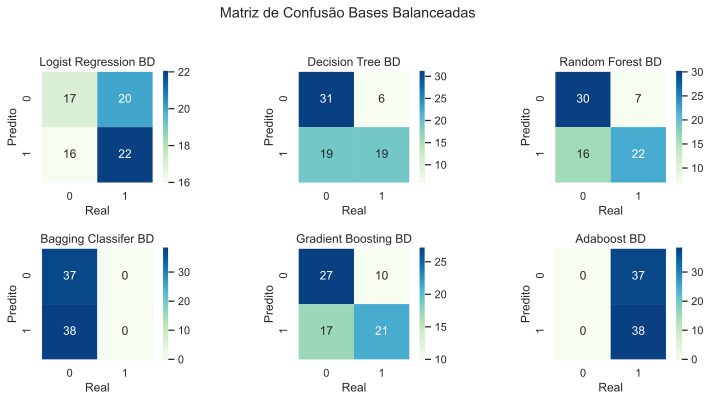

In [37]:
matriz_consol_bd()

C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BaggingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sabri\Anaconda3\lib\site-packages\sklearn\base.py:450: U

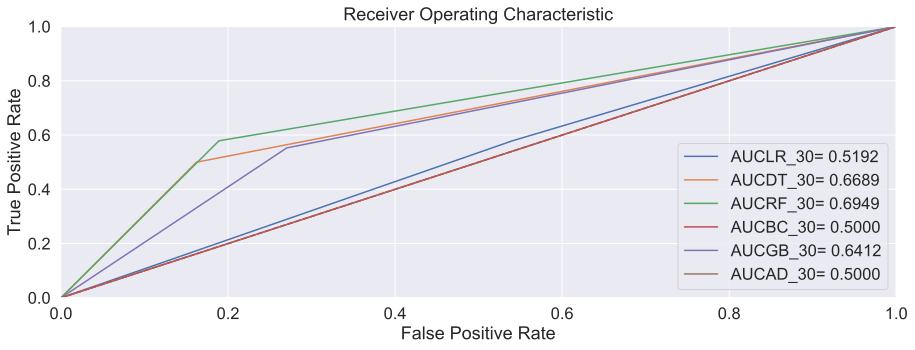

In [38]:
CurvaAuc(X_test,y_test, lr_30_bd, dt_30_bd, rf_30_bd, bc_30_bd, gb_30_bd, adb_30_bd, 
             "LR_30","DT_30","RF_30","BC_30","GB_30","AD_30", "AUC_Bases_Balanceadas_30_1")

# Análise de Resultados¶

ACURÁCIA = é uma boa indicação geral de como o modelo performou. Porém, pode haver situações em que ela é enganosa.A proporção de predições corretas, sem levar em consideração o que é positivo e o que é negativo. Esta medida é altamente suscetivel a desbalanceamentos do conjunto de dados e pode facilmente induzir a uma conclusão errada sobre o desempenho do modelo.

RECALL/SENSIBILIDADE/taxa de acerto/taxa positiva verdadeira/revocação = A proporção de verdadeiros positivos: a capacidade do modelo em predizer corretamente a condição para casos que realmente a têm. Pode ser usada em uma situação em que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Essa métrica avalia a capacidade do método de detectar com sucesso resultados classificados como positivos

ESPECIFICIDADE/seletividade/taxa negativa verdadeira = A proporção de verdadeiros negativos: a capacidade do sistema em predizer corretamente a ausência da condição para casos que realmente não a têm.Avalia a capacidade do método de detectar resultados negativos

EFICIÊNCIA = A média aritmética da Sensibilidade e Especificidade. Na prática, a sensibilidade e a especificidade variam em direções opostas. Isto é, geralmente, quando um método é muito sensível a positivos, tende a gerar muitos falso-positivos, e vice-versa. Assim, um método de decisão perfeito (100 % de sensibilidade e 100% especificidade) raramente é alcançado, e um balanço entre ambos deve ser atingido.

AUC - Area Under the ROC Curve = Esta é uma métrica interessante para tarefas com classes desproporcionais. Nela, mede-se a área sob uma curva formada pelo gráfico entre a taxa de exemplos positivos, que realmente são positivos, e a taxa de falsos positivos. Uma das vantagens em relação ao F1 Score, é que ela mede o desempenho do modelo em vários pontos de corte, não necessariamente atribuindo exemplos com probabilidade maior que 50% para a classe positiva, e menor, para a classe negativa. Em sistemas que se interessam apenas pela classe, e não pela probabilidade, ela pode ser utilizada para definir o melhor ponto de corte para atribuir uma ou outra classe a um exemplo. Este ponto de corte normalmente é o ponto que se localiza mais à esquerda, e para o alto, no gráfico, mas depende bastante do custo do erro na previsão de uma determinada classe.

PRECISÃO/VALOR PREDITIVO POSITIVO = A proporção de verdadeiros positivos em relação a todas as predições positivas. Esta medida é altamente suscetivel a desbalanceamentos do conjunto de dados e pode facilmente induzir a uma conclusão errada sobre o desempenho do sistema. Dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas. Pode ser usada em uma situação em que os Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos.

VALOR PREDITIVO NEGATIVO = A proporção de verdadeiros negativos em relação a todas as predições negativas. Esta medida é altamente suscetivel a desbalanceamentos do conjunto de dados e pode facilmente induzir a uma conclusão errada sobre o desempenho do sistema

COEFICIENTE DE CORRELAÇÃO DE MATTHEWS – COEFICIENTE (PHI) = Retorna um valor entre (-1) e (+1), em que um coeficiente de (+1) representa uma predicao perfeita, (0) representa uma predicao aleatoria media, e (-1) uma predicao inversa.

F–measure, F-score ou score F1 = O F1 Score é uma média harmônica entre precisão e recall. Ela é muito boa quando você possui um dataset com classes desproporcionais, e o seu modelo não emite probabilidades. Isso não significa que não possa ser usada com modelos que emitem probabilidades, tudo depende do objetivo de sua tarefa de machine learning. Em geral, quanto maior o F1 score, melhor. é simplesmente uma maneira de observar somente 1 métrica ao invés de duas (precisão e recall) em alguma situação. É uma média harmônica entre as duas, que está muito mais próxima dos menores valores do que uma média aritmética simples. Ou seja, quando tem-se um F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo.

https://www.mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/


In [39]:

#tabelona = pd.concat([tabela_LogistRegressionBasesDesbalanceadas,tabela_LogistRegressionNearMiss,
#                      tabela_LogistRegressionSMOTE,tabela_DecisionTreeBasesDesbalanceadas,tabela_DecisionTreeNearMiss,tabela_DecisionTreeSMOTE,
#                     tabela_RandomForestBasesDesbalanceadas,tabela_RandomForestNearMiss,tabela_RandomForestSMOTE,tabela_BaggingClassifierBaseDesbalanceadas,
#                     tabela_BaggingClassifierNearMiss,tabela_BaggingClassifierSMOTE,tabela_GradianteBoostingBasesDesbalanceadas,
#                     tabela_GradianteBoostingNearMiss,tabela_GradianteBoostingSMOTE,tabela_AdaBoostBasesDesbalanceadas,
#                     tabela_AdaBoostNearMiss,tabela_AdaBoostSMOTE],axis=1)
#tabelona

In [40]:
tabelona = pd.concat([tabela_LogistRegressionBasesBalanceadas,tabela_DecisionTreeBasesBalanceadas,
                      tabela_RandomForestBasesBalanceadas,tabela_BaggingClassifierBasesBalanceadas,
                      tabela_GradianteBoostingBasesBalanceadas,tabela_AdaBoostBasesBalanceadas],axis=1)
tabelona

,Logist Regression Bases Balanceadas,Decision Tree Bases Balanceadas,Random Forest Bases Balanceadas,Bagging Classifier Bases Balanceadas,Gradiente Boosting Bases Balanceadas,AdaBoost Bases Balanceadas
Acurácia,52.0%,66.67%,69.33%,49.33%,64.0%,50.67%
Valor Preditivo Positivo,52.38%,76.0%,75.86%,0%,67.74%,50.67%
Valor Preditivo Negativo,51.52%,62.0%,65.22%,48.65%,61.36%,0%
Sensibilidade,57.89%,50.0%,57.89%,0.0%,55.26%,100.0%
Especificidade,45.95%,83.78%,81.08%,97.3%,72.97%,0.0%
Eficiência,51.92%,66.89%,69.48%,48.65%,64.11%,50.0%
Coeficiente phi,0.04,0.36,0.4,-0.12,0.29,0
F1 Score,55.0,60.32,65.67,0,60.87,67.26
AUC,0.519,0.669,0.695,0.5,0.641,0.5


In [41]:
tabelona_30 = tabelona
tabelona_30.to_excel('Resultado_30_TV_CV.xlsx', index = False)

# Permutation feature importance - Random Forest - Atraso >=30

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

# Permutation Importance Random Forest na base de treino

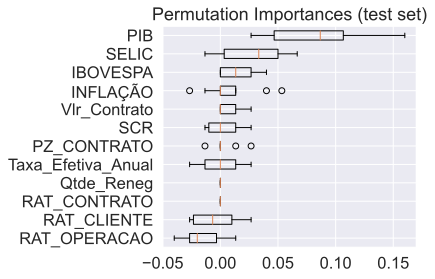

In [66]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y
#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

rf_30_bd = RandomForestClassifier (class_weight=None, n_estimators=100, max_depth=5, min_samples_split=2,
                                   min_samples_leaf=3, 
                                   max_features='sqrt', bootstrap=True,random_state = 10)
    
rf_30_bd.fit(X_train, y_train)

result = permutation_importance(rf_30_bd, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.savefig('Permutation Importances test set_30_TV_1',dpi = 300,bbox_inches='tight')
plt.show()

In [67]:
def permutation_01(X_train, y_train, X_test, y_test):
    
    rf_30_bd = RandomForestClassifier (class_weight=None, n_estimators=100, max_depth=5, min_samples_split=2,
                                   min_samples_leaf=3, 
                                   max_features='sqrt', bootstrap=True,random_state = 10)
    
    rf_30_bd.fit(X_train, y_train)
    
    result = permutation_importance(rf_30_bd, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (test set)")
    fig.tight_layout()
    plt.show()

In [68]:
def permutation_02(X_train, y_train, X_test, y_test):
    
    rf_30_bd = RandomForestClassifier (class_weight=None, n_estimators=100, max_depth=5, min_samples_split=2,
                                   min_samples_leaf=3, 
                                   max_features='sqrt', bootstrap=True,random_state = 10)
    
    rf_30_bd.fit(X_train, y_train)
    
    result = permutation_importance(rf_30_bd, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
    
    sorted_idx = result.importances_mean.argsort()
    
    fig, ax = plt.subplots()
    ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
    ax.set_title("Permutation Importances (train set)")
    fig.tight_layout()
    plt.savefig('Permutation Importances train set_30_TV_1',dpi = 300,bbox_inches='tight')
    plt.show()

In [69]:
#Isolando a variável dependente, sem modificar o dataframe de modo permanente
X = df_30.drop("Y", axis =1)
y = df_30.Y
#aqui o padrão é 70% dos dados para treino e 30% para teste
#random seria a aleatoriedade
#stratify ele vai embaralhar oa dados

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 10, stratify=y)

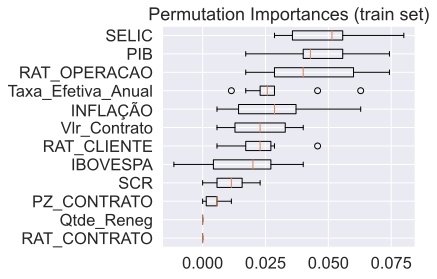

In [70]:
permutation_02(X_train, y_train, X_test, y_test)

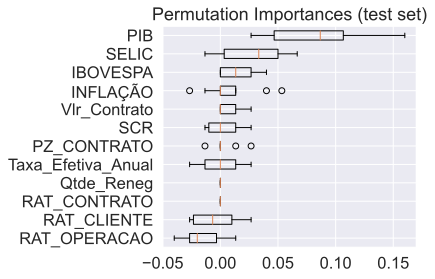

In [71]:
permutation_01(X_train, y_train, X_test, y_test)

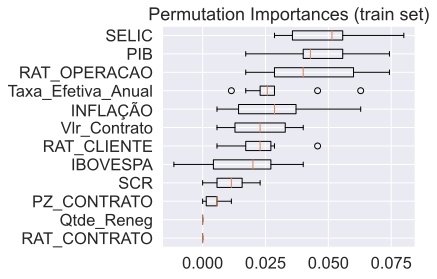

In [72]:
permutation_02(X_train, y_train, X_test, y_test)